# Multi objective optimization post-processing analysis

In [2]:
using Revise
using FUSE
using JLD2
using Plots;
gr();

# Process data

## Choose run directory

In [3]:
#result_path = "study_1/opt_betaN_cost__Solovev_Paux30_flattop24/"; run_dir = "gen_runs3"
#result_path = "study_1/opt_betaN_cost__Solovev_Paux30_flattop48/"; run_dir = "gen_runs6"
#result_path = "study_1/opt_betaN_cost__Solovev_Paux30_flattop72/"; run_dir = "gen_runs5"

#result_path = "study_1/opt_betaN_R0__Solovev_Paux30_flattop24/"; run_dir = "gen_runs3"
#result_path = "study_1/opt_betaN_R0__Solovev_Paux30_flattop48/"; run_dir = "gen_runs6"
#result_path = "study_1/opt_betaN_R0__Solovev_Paux30_flattop72/"; run_dir = "gen_runs6"

#result_path = "study_1/opt_betaN_cost__Solovev_flattop24/"; run_dir = "gen_runs6"
result_path = "study_1/opt_betaN_cost__Solovev_flattop48/"; run_dir = "gen_runs4"
#result_path = "study_1/opt_betaN_cost__Solovev_flattop72/"; run_dir = "gen_runs1"

#result_path = "study_1/opt_betaN_cost__TEQUILA_Paux30_flattop48/"; run_dir = "gen_runs4"

#result_path = "study_1/opt_betaN_cost__Solovev_Paux30_Bt5.0_flattop48/"; run_dir = "gen_runs3"
#result_path = "study_1/opt_betaN_cost__Solovev_Paux30_Bt6.0_flattop48/"; run_dir = "gen_runs6"
#result_path = "study_1/opt_betaN_cost__Solovev_Paux30_Bt7.0_flattop48/"; run_dir = "gen_runs5"

"gen_runs4"

## Load results from cache file

In [4]:
cache_path = result_path * run_dir
all_dirs = filter(isdir, sort(readdir(cache_path; join=true)))
println(length(all_dirs))

dirs = sort(filter(x -> !isfile(joinpath(x, "error.txt")) && isfile(joinpath(x, "dd.json")), all_dirs))
println(length(dirs))

IMAS.update_ExtractFunctionsLibrary!(); # to pick up any ongoing development to extract function library

outputs = FUSE.extract(dirs; filter_invalid=:cols, cache=joinpath(cache_path, "extract.csv"), read_cache=true, write_cache=true);


64
64


[ Info: Loaded cache file with 64 results
Progress: 100%|███████████████████████████| Time: 0:00:17 ( 0.27  s/it)
[ Info: Written cache file with 64 results


In [5]:
typeof(outputs)

DataFrames.DataFrame

## Error analysis

In [6]:
using StatsPlots

errors = FUSE.categorize_errors(all_dirs; do_plot=true, show_first_line=false)
err = errors[:other][end]
#println(read(err * "/error.txt",String))

x = Dict()
h = Dict()
ngen = (length(all_dirs)+5*256) / 256 / 2
nbins = Int(ngen)
bins = StepRange(1,floor(length(all_dirs) ÷ nbins),length(all_dirs))

for key in keys(errors)
    x[key] = indexin(errors[key],sort(all_dirs))
    h[key] = []
    for (b0,b1) in zip(bins[1:end-1],bins[2:end])
        n = length(findall((x[key] .< b1) .* (x[key] .> b0)))
        h[key] = [h[key]; n]
    end
end

data = [h[key] for key in keys(errors)]
nticks = nbins
xticks = (0:1:nbins, [string(x) for x in LinRange(0,ngen,nticks)])

g = groupedbar(convert(Matrix{Int},reduce(hcat, data)) ./ (length(all_dirs)/nbins) * 100, 
    bar_position=:stack,
    label=String.(reduce(hcat,keys(errors))),
    xlabel="Generation",
    ylabel="Percentage of FUSE runs (%)",
    title ="Error codes",
    legend=:outerright,
    #xticks=xticks,
    left_margin = 5Plots.mm,
    bottom_margin = 8Plots.mm,
    )

display(plot(g,size=(800,450)))



LoadError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

## New derived quantities

In [7]:
n = length(outputs[:,1])
outputs[:, "run"] = 1:n

outputs[:,"nGW"] = @. outputs[:,"ip"]/(π * (outputs[:,"a"])^2)*1e20
outputs[:,"fGW_ped"] = @. outputs[:,"ne_ped"]/outputs[:,"nGW"]
outputs[:,"fLH"] = @. outputs[:,"Psol"] / outputs[:,"PLH"];
outputs[:,"fBS"] = @. outputs[:,"ip_bs"]/outputs[:,"ip_bs_aux_ohm"]
outputs[:,"accessEC"] = @. 89.9 * (outputs[:,"ne0"]/1e20)^0.5 / (28.0 * outputs[:,"B0"]);


In [8]:
println(names(outputs))

["1/ϵ", "<Bpol>", "<P>", "<Te>", "<Ti>", "<ne>", "<zeff>", "B0", "Bpol_omp", "H98y2", "Hds03", "Nw_peak", "OH_j_margin", "OH_material", "OH_max_b", "OH_stress_margin", "P/R0", "P0", "P0/<P>", "PB/R0", "PBp/R0", "PF_material", "PLH", "Paux_tot", "Pec", "Pelectric_net", "Pfusion", "Prad_tot", "Psol", "Qfusion", "Qplant", "R0", "Surface", "TBR", "TF_j_margin", "TF_material", "TF_max_b", "TF_stress_margin", "Te0", "Te0/<Te>", "Ti0", "Ti0/<Ti>", "Volume", "a", "capital_cost", "dir", "fGW", "flattop", "ip", "ip_aux", "ip_bs", "ip_bs_aux_ohm", "ip_ni", "ip_ohm", "levelized_CoE", "ne0", "ne0/<ne>", "ne_ped", "q95", "qpar", "qpol", "zeff_ped", "βn", "βn_MHD", "βn_th", "βpol_MHD", "βtor_MHD", "δ", "ζ", "ηthermal_cycle", "κ", "λq", "τe", "run", "nGW", "fGW_ped", "fLH", "fBS", "accessEC"]


## Filter based on constraints

In [9]:
# Selection criterion
min_Pelectric = 200
min_fLH = 1.0
max_accessEC = 1
max_ds03 = 1.0
max_Sn = 1.5
max_qpol = 2.75e3
min_TF_j_margin = 1.5
min_OH_j_margin = 1.5
min_TF_stress_margin = 1.0
min_OH_stress_margin = 1.0

n = length(outputs[:,1])
index = 1:n
index = findall(
    (outputs[:, "Pelectric_net"] .> min_Pelectric) .&& 
    (outputs[:, "fLH"] .> min_fLH) .&& 
    (outputs[:, "accessEC"] .< max_accessEC) .&& 
    (outputs[:, "Hds03"] .< max_ds03) .&& 
    (outputs[:, "ne0/<ne>"] .< max_Sn) .&& 
    (outputs[:, "qpol"] .< max_qpol) .&&
    (outputs[:, "TF_j_margin"] .> min_TF_j_margin) .&&
    (outputs[:, "OH_j_margin"] .> min_OH_j_margin) .&&
    (outputs[:, "TF_stress_margin"] .> min_TF_stress_margin) .&&
    (outputs[:, "OH_stress_margin"] .> min_OH_stress_margin) )

println("$(n) valid runs")
println("$(length(index)) filtered points")

64 valid runs
54 filtered points


# Visualize data

## Plot evolution of key scalar quantities

In [10]:
# option to filter based on single parameter
if false
    t = outputs[:, "Hds03"]
    max_t = 0.95
    n = length(outputs[:,1])
    r = 1:n
    r = findall(t .< max_t)
# otherwise, either show whole dataset or fully-filtered subset    
else
    #r = index
    r = 1:n
end

N = length(outputs[r, "Pelectric_net"])

X = LinRange(1, N, 50)

import Statistics
function y_auto_range(y; σ=5, N=50)
    y_nonan = y[@. !isnan.(y)]
    m = Statistics.median(y_nonan)
    s = Statistics.median(Statistics.median(abs.(y_nonan .- m))) * σ
    Y = LinRange(max(m - s, minimum(y_nonan)), min(m + s, maximum(y_nonan)), N)
end

clim = missing

missing

### plot typical inputs

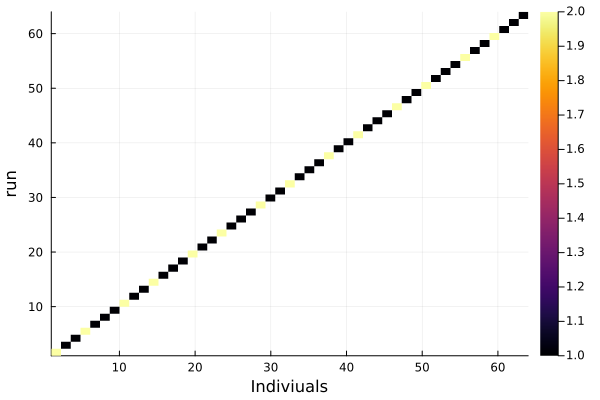

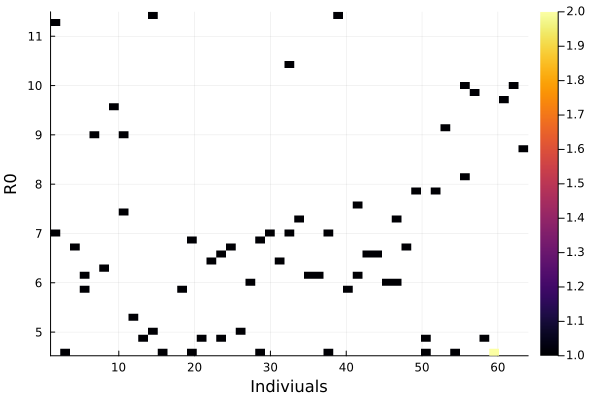

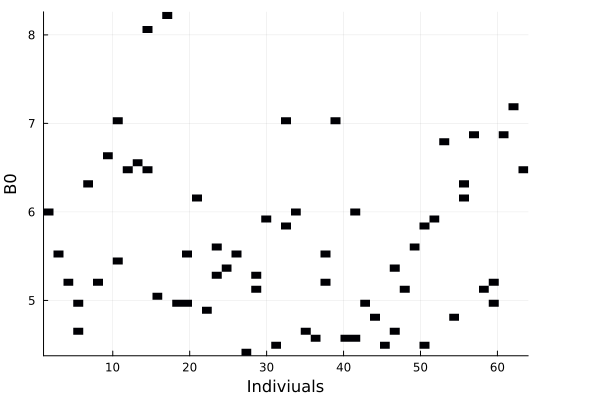

GKS: Possible loss of precision in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
origin outside current window


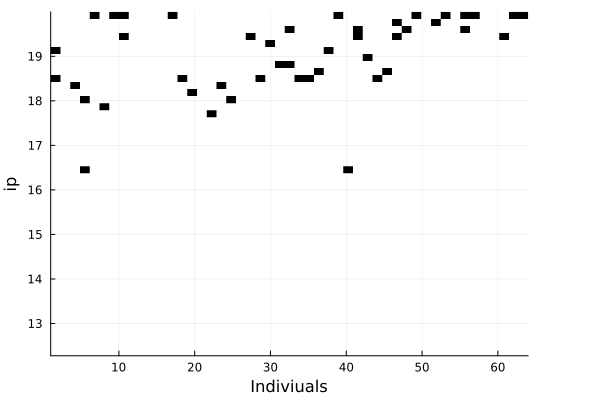

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
origin outside current window


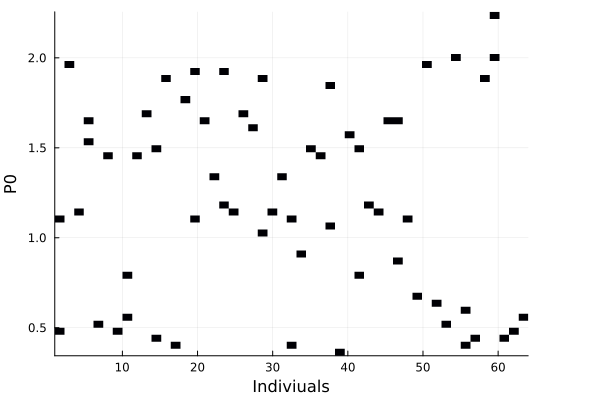

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range


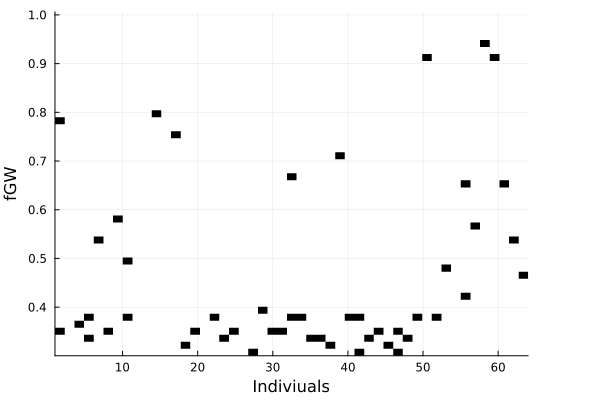

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range


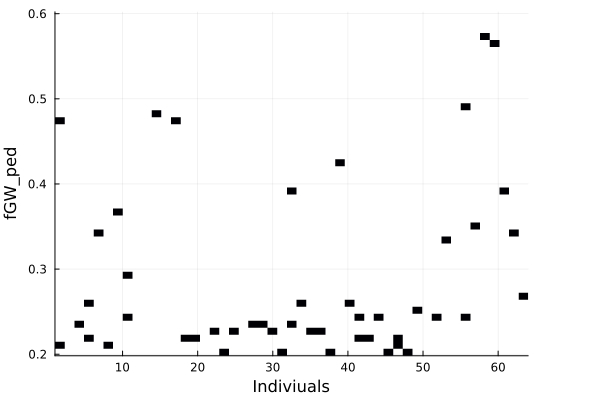

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
origin outside current window


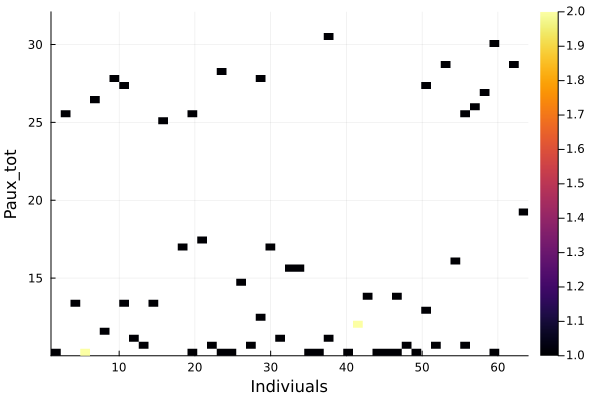

In [11]:
vars = ["run", "R0", "B0", "ip", "P0", "fGW", "fGW_ped", "Paux_tot"]

for var in vars

    y = outputs[r, var]
    yname = var
    Y = y_auto_range(y)
    p = histogram2d(y, bins=(X, Y), ylabel=yname, xlabel="Indiviuals", clim=clim)
    display(p)

end


### plot typical objective functions

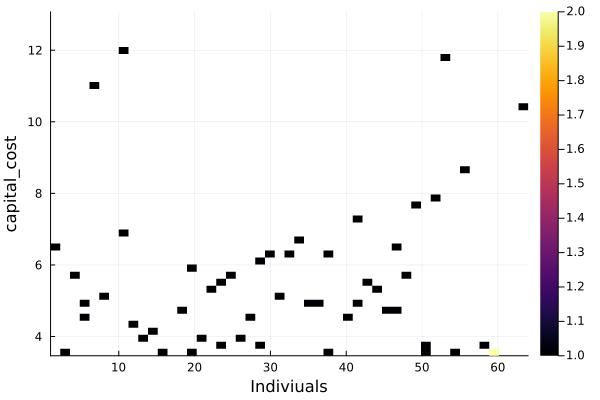

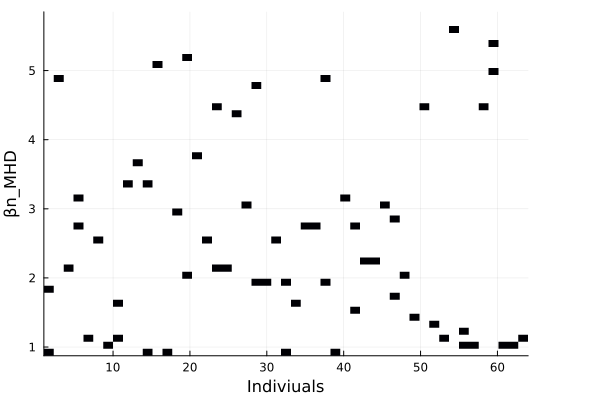

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range


In [12]:
vars = ["capital_cost", "βn_MHD"]

for var in vars

    y = outputs[r, var]
    yname = var
    Y = y_auto_range(y)
    p = histogram2d(y, bins=(X, Y), ylabel=yname, xlabel="Indiviuals", clim=clim)
    display(p)

end


### plot typical output constraints

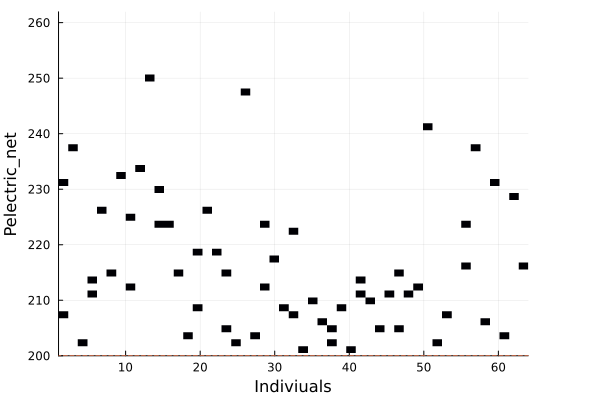

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
origin outside current window


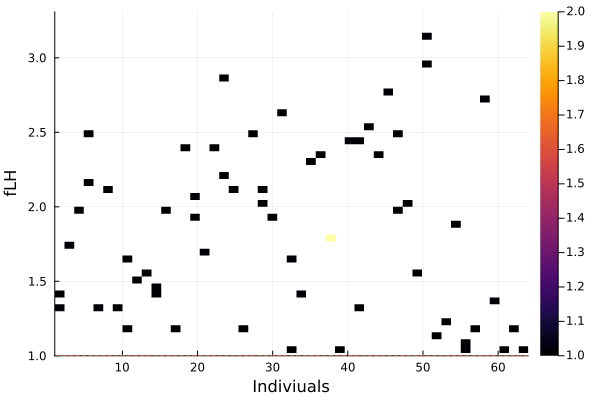

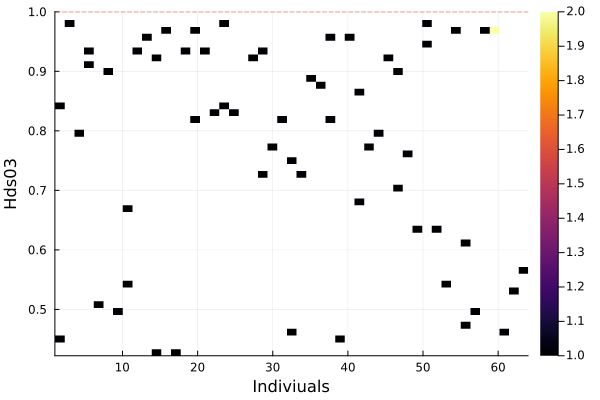

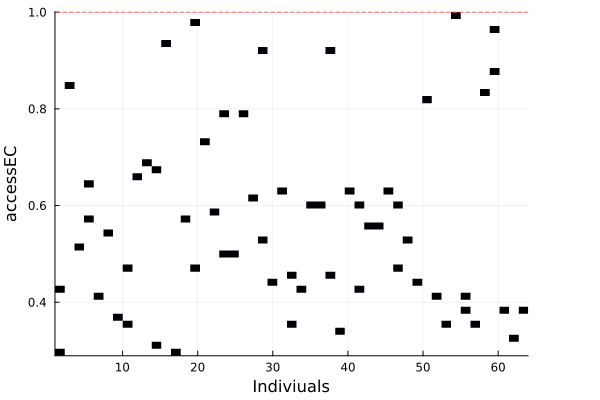

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range


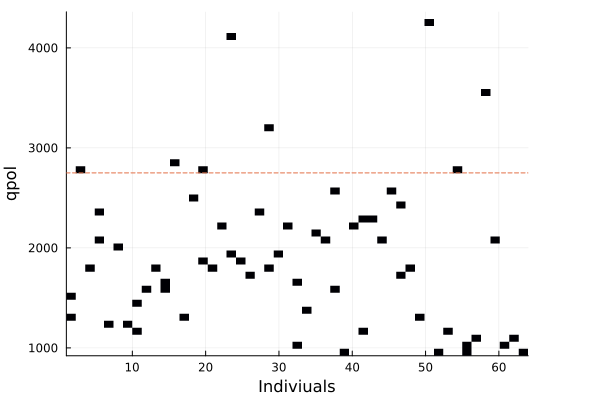

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
origin outside current window


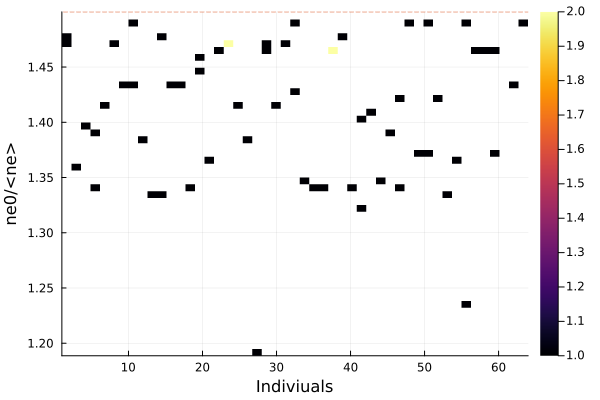

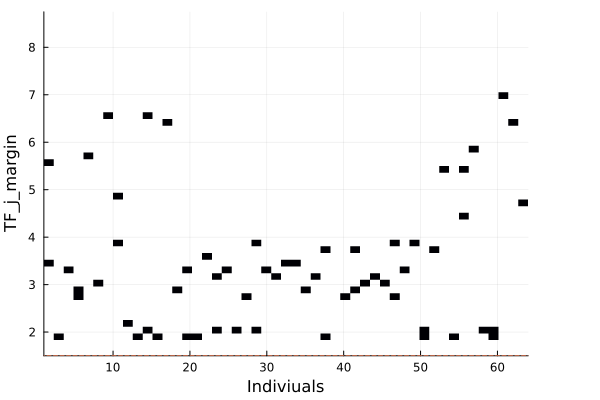

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
origin outside current window


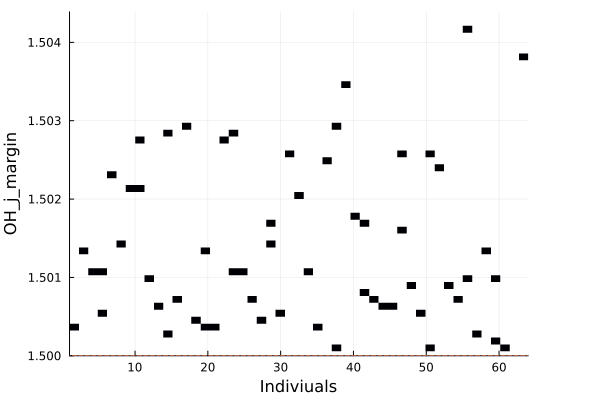

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
origin outside current window


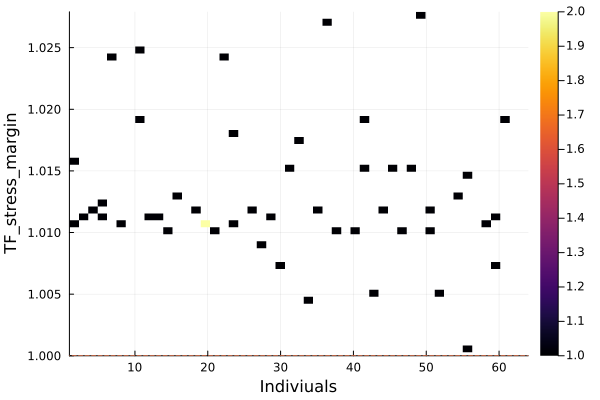

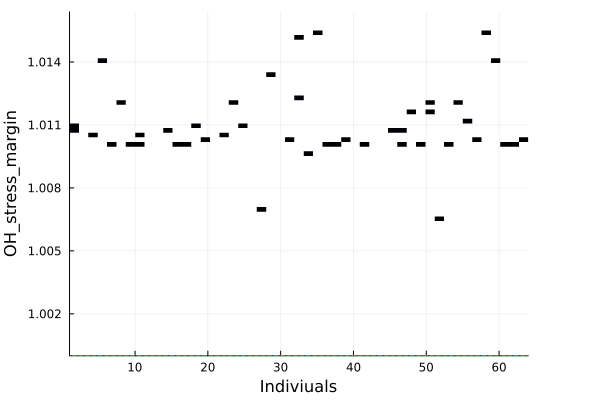

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range


In [13]:
vars = ["Pelectric_net", "fLH", "Hds03", "accessEC", "qpol", "ne0/<ne>", "TF_j_margin", "OH_j_margin", "TF_stress_margin", "OH_stress_margin"]
constraints = [200, 1.0, 1.0, 1.0, 2.75e3, 1.5, 1.5, 1.5, 1.0, 1.0]

for (var, constraint) in zip(vars, constraints)

    y = outputs[r, var]
    yname = var
    Y = y_auto_range(y)
    p = histogram2d(y, bins=(X, Y), ylabel=yname, xlabel="Indiviuals", clim=clim)
    hline!([constraint], ls=:dash, label="")
    display(p)

end


### plot other informative outputs

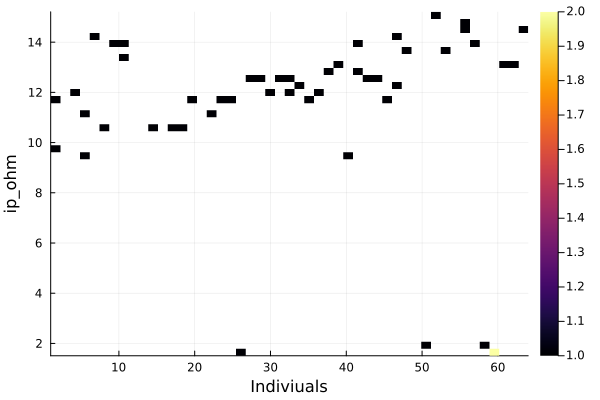

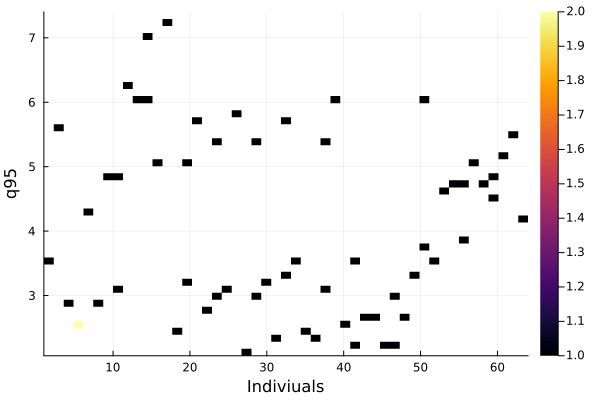

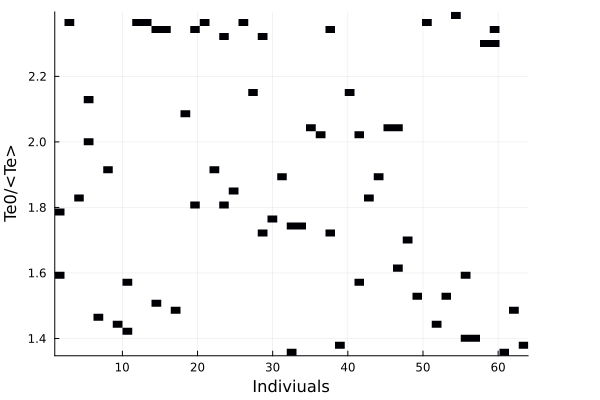

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
origin outside current window


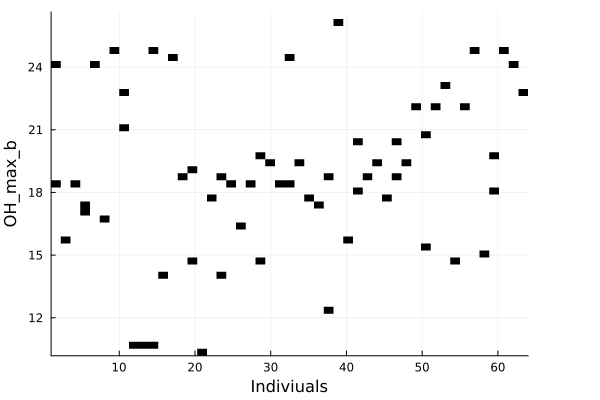

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
origin outside current window


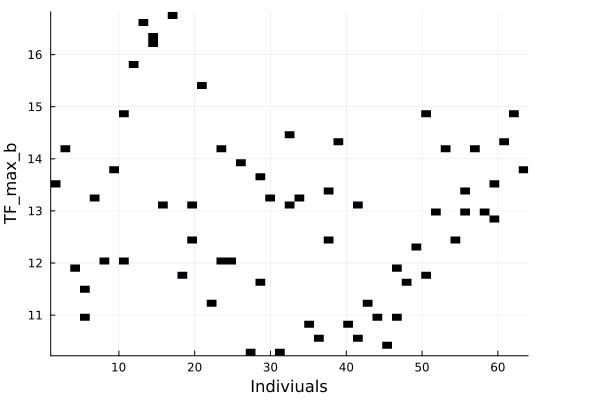

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
origin outside current window


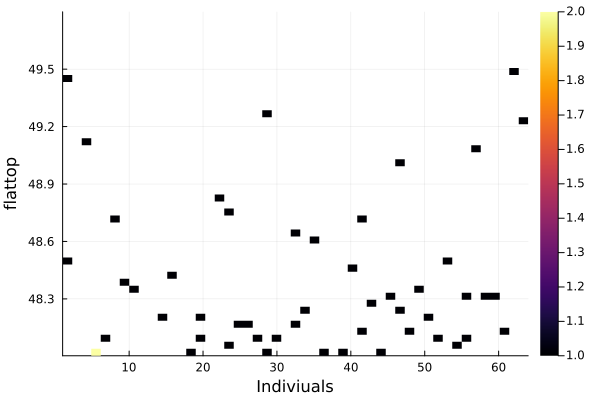

In [14]:
vars = ["ip_ohm","q95","Te0/<Te>","OH_max_b","TF_max_b","flattop"]

for (var, constraint) in zip(vars, constraints)

    y = outputs[r, var]
    yname = var
    Y = y_auto_range(y)
    p = histogram2d(y, bins=(X, Y), ylabel=yname, xlabel="Indiviuals", clim=clim)
    display(p)

end

## Plot in optimization space

54
[39, 17, 15, 1, 33, 62, 61, 57, 9, 55, 11, 53, 7, 63, 56, 52, 49, 41, 10, 34, 46, 2, 32, 30, 38, 28, 19, 48, 25, 4, 23, 43, 44, 22, 8, 31, 6, 42, 36, 35, 47, 18, 45, 27, 40, 5, 12, 14, 13, 21, 26, 64, 37, 59]


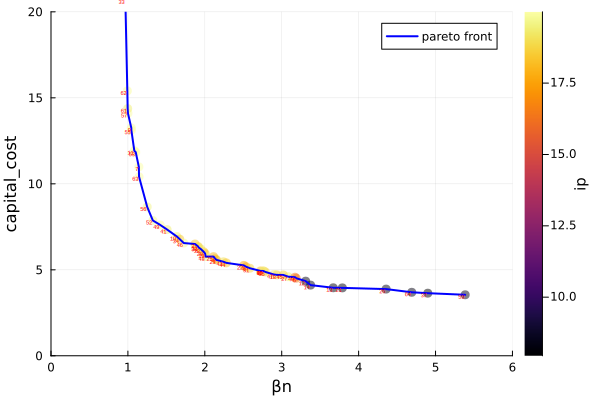

In [15]:
gr()

# x axis
xname = "βn";
x = outputs[:, xname];

#xname="βpol"; x=outputs[:,xname]
#xname="Pec [MW]"; x=outputs[:,"Pec"]

# y axis
yname = "capital_cost";

#yname="ip_bs/ip_bs_aux_ohm"; y=outputs[:,"ip_bs"]./outputs[:,"ip_bs_aux_ohm"];
#yname="Pec=R0*ne*ip_aux(5+zeff)/(Te*0.09)"; y= @. outputs[:,"<ne>"]/1E20*outputs[:,"R0"]*outputs[:,"ip_aux"]*(5.0+outputs[:,"<zeff>"])/(0.09*outputs[:,"<Te>"])
y = outputs[:, yname];

# color
cname="run"; c=outputs[:, "run"];clim=(-Inf,Inf);
#cname="log10(flattop)"; c=log10.(outputs[:,"flattop"]);clim=(-Inf,Inf);
#cname="flattop"; c=outputs[:,"flattop"];clim=(-Inf,Inf);
#cname="Pelectric_net"; c=outputs[:,cname];clim=(200,300);
#cname="Ip aux [MA]"; c=outputs[:,"ip_aux"];clim=(-Inf,Inf);
#cname="fGW"; c=outputs[:,"fGW"];clim=(-Inf,Inf);
#cname="<zeff>"; c=outputs[:,"<zeff>"];clim=(-Inf,Inf);
#cname="R0 [m]"; c=outputs[:,"R0"];clim=(-Inf,8);
#cname="B0 [T]"; c=outputs[:,"B0"];clim=(-Inf,Inf);
#cname="B0*R0 [T*m]"; c=outputs[:,"B0"].*outputs[:,"R0"];clim=(-Inf,Inf);
#cname="ip_ohm"; c=outputs[:,cname];clim=(-Inf,Inf);
cname="ip"; c=outputs[:,cname];clim=(-Inf,Inf);
#cname = "q95"; c = outputs[:, cname]; clim = (-Inf, Inf);
#cname = "1/ϵ"; c = outputs[:, "R0"]./outputs[:, "a"]; clim = (-Inf, Inf);
#cname="Pec [MW]"; c=outputs[:,"Pec"];clim=(-Inf,Inf);
#cname="ip_bs_aux_ohm/ip"; c=outputs[:,"ip_bs_aux_ohm"]./outputs[:,"ip"];clim=(-Inf,Inf);
#cname="ip_ohm"; c=abs.(outputs[:,"ip_ohm"]);clim=(-Inf,Inf);
#cname="ip_bs_aux_ohm/ip"; c=outputs[:,"ip_bs_aux_ohm"]./outputs[:,"ip"];clim=(-Inf,Inf);
#cname="Ip aux [MA]"; c=outputs[:,"ip_aux"];clim=(-Inf,Inf);
#cname="qpol [MW/m^2]"; c=outputs[:,"qpol"];clim=(-Inf,2.75e3);
#cname="fLH"; c=outputs[:,"fLH"];clim=(-Inf,2);
#cname="βn_th"; c=outputs[:,"βn_th"];clim=(-Inf,5);

#cname="HTS"; c=(outputs[:,"TF_material"].=="ReBCO").+(outputs[:,"OH_material"].=="ReBCO").*2.0; clim=(0,4)

if true
    xs = x[index]
    ys = y[index]
    cs = c[index]
else
    xs = x
    ys = y
    cs = c
end
    
annot = map(x -> (x, :center, 3, "courier"), index)
P = scatter(xs, ys, marker_z=cs, xlabel=xname, ylabel=yname, colorbar_title=cname, marker=:circle,
    markersize=5, markerstrokewidth=0, label="", clim=clim, alpha=0.5,
    #    series_annotations=annot,
    ylim=(0, 20), xlim=(0, 6),
    )

# Pareto front
pindex = index[FUSE.pareto_front([[x[index[k]], y[index[k]]] for k in 1:length(index)])]
sort!(pindex, by=i -> y[i])
sort!(pindex, by=i -> x[i])
println(length(pindex))
println(pindex)
pannot = map(x -> ("\n$x", :right, 3, "courier", :red), pindex)
plot!(P, x[pindex], y[pindex], series_annotations=pannot, color=:blue, label="pareto front", lw=2);
#plot!(P, x[pindex], y[pindex], color=:blue, label="pareto front", lw=2);

display(P)

## 1D plots of Pareto solutions

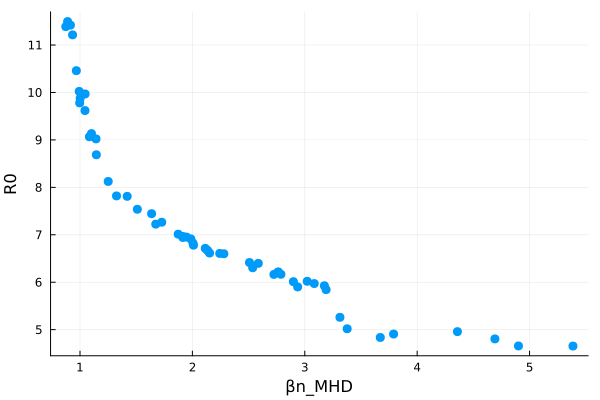

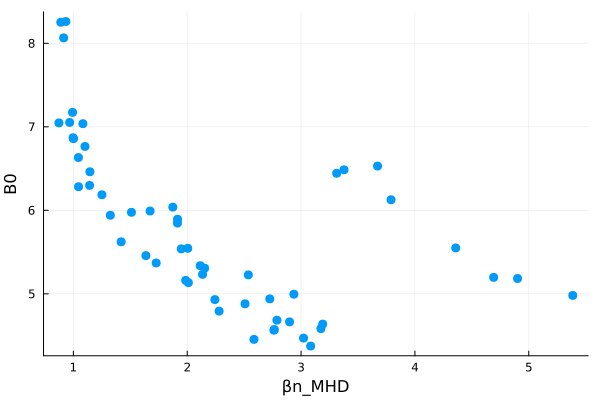

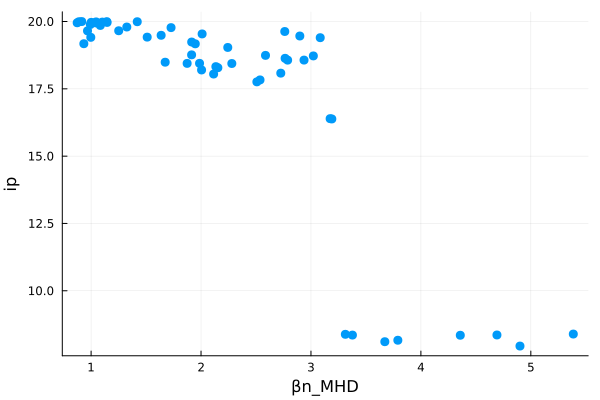

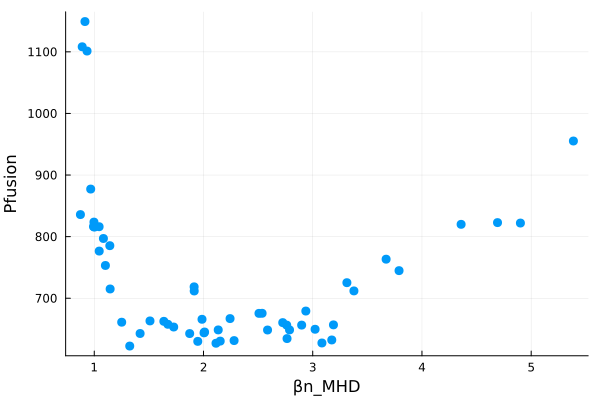

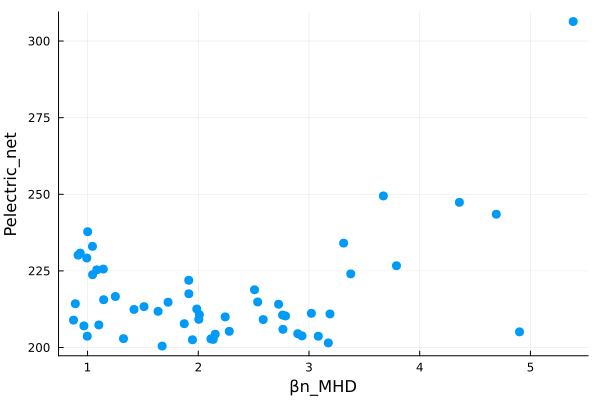

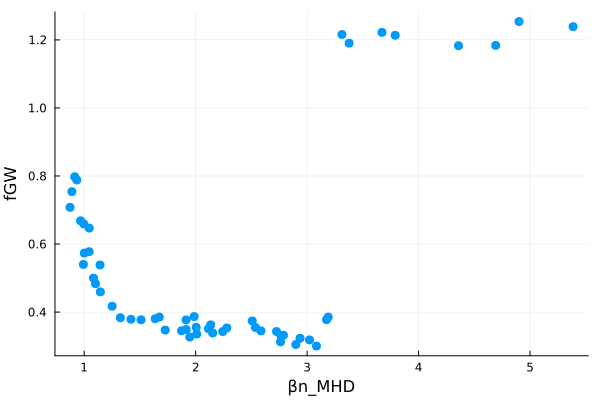

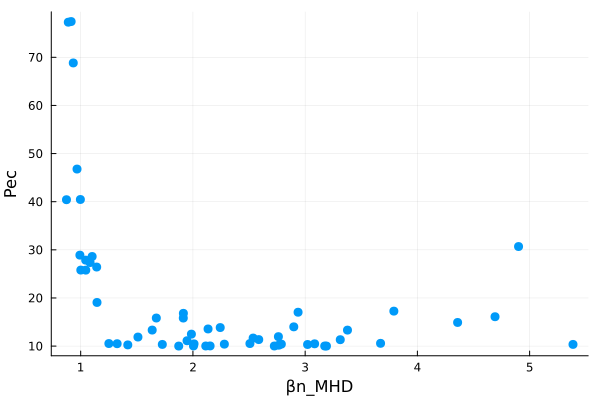

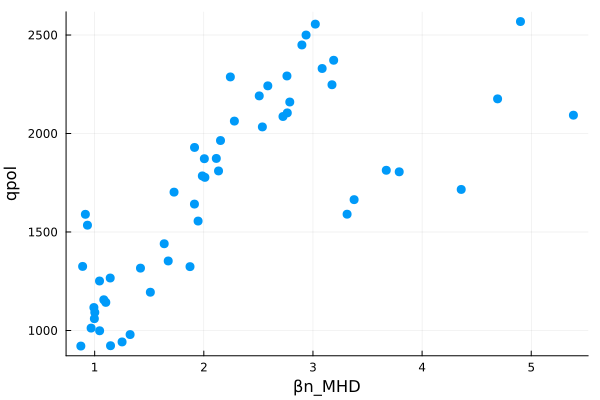

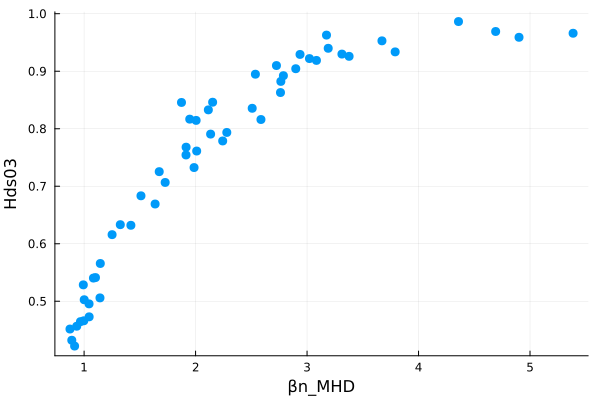

In [16]:
xname = "βn_MHD" 
yname_list = ["R0","B0","ip","Pfusion","Pelectric_net","fGW","Pec","qpol","Hds03"]

for yname in yname_list 
    P = scatter(outputs[pindex,xname], outputs[pindex,yname], xlabel=xname, ylabel=yname,marker=:circle,
    markersize=5, markerstrokewidth=0, lw=1, label="")
    display(P)
end

## Plot correlation between parameters

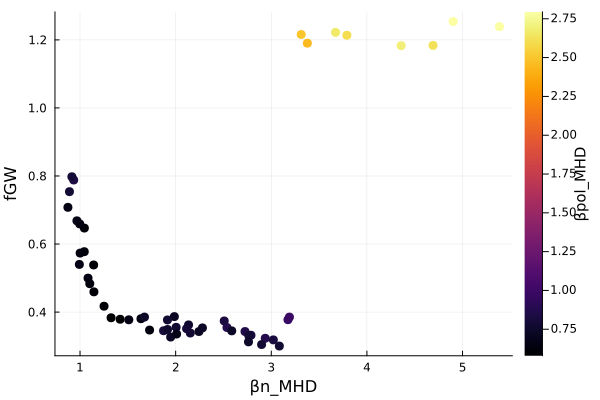

In [23]:
#x = outputs[index, "fGW"] ./ outputs[index, "fGW_ped"]
#y = outputs[index, "ne0"] ./ outputs[index, "<ne>"]

xname = "βn_MHD"
yname = "fGW"

x = outputs[index, xname] 
y = outputs[index, yname]

c = outputs[index, "βpol_MHD"]; cname = "βpol_MHD"; clim = (-Inf, Inf)
#c = outputs[index, "Pfusion"]; cname = "Pfusion"; clim = (-Inf, Inf)

P = scatter(x, y, marker_z=c, colorbar_title=cname, marker=:circle,
    markersize=5, markerstrokewidth=0, label="", clim=clim, alpha=1.0, z_order=:back,
    xlabel = xname, ylabel=yname,
    #xlim = (1,2), ylim = (0.8,2),
    )

xl = LinRange(0,2,100)

#plot!(P, xl, xl.*1, label="y=x")
#plot!(P, xl, xl.*0.9, label="y=0.9x")
#plot!(P, xl, xl.*0.8, label="y=0.8x")

display(P)


## Plot digest for single case

13

/fusion/ga/projects/ird/ptp/weisbergd/julia/dev/FUSE/playground/weisberg_FPP_opt/study_1/opt_betaN_cost__Solovev_flattop48/gen_runs4/1__2023-09-19T01:38:08.890__3919414


┌ Error: reading act.ActorDivertors.impurities : TypeError(:setfield!, "", Union{Missing, Function, Vector{Symbol}}, Float64[])
└ @ SimulationParameters ~/.julia/dev/SimulationParameters/src/utils.jl:92


GEOMETRY                        EQUILIBRIUM                     TEMPERATURES                    DENSITIES                       
────────────────────────────    ────────────────────────────    ────────────────────────────    ────────────────────────────    
R0 → 4.84 [m]                   B0 → 6.53 [T]                   Te0 → 24.9 [keV]                ne0 → 1.96e+20 [m⁻³]            
a → 1.38 [m]                    ip → 8.11 [MA]                  Ti0 → 20.5 [keV]                ne_ped → 1.15e+20 [m⁻³]         
1/ϵ → 3.5 [m]                   q95 → 6.01                      <Te> → 10.5 [keV]               <ne> → 1.47e+20 [m⁻³]           
κ → 2.14                        <Bpol> → 0.702 [T]              <Ti> → 8.95 [keV]               ne0/<ne> → 1.33                 
δ → 0.675                       βpol_MHD → 2.67                 Te0/<Te> → 2.37                 fGW → 1.22                      
ζ → -0.114                      βtor_MHD → 0.033                Ti0/<Ti> → 2.29                 z

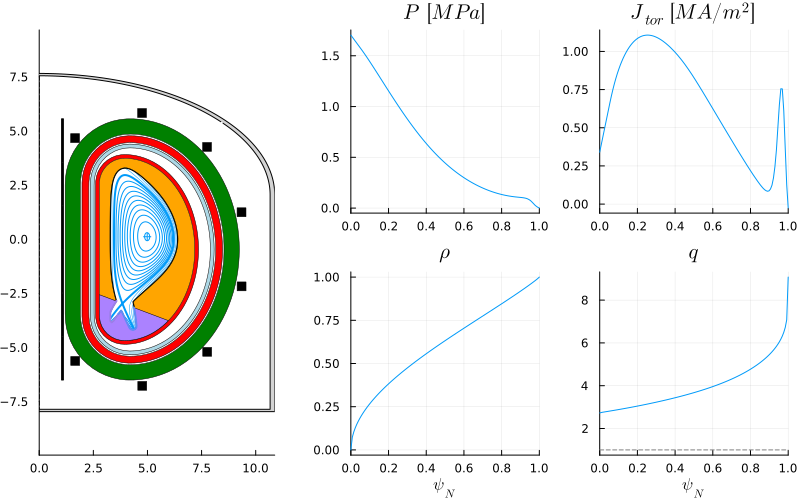

​


24×9 DataFrame
 Row │ group   details     type      ΔR         R_start   R_end     material      area       volume     
     │ String  String      String    Float64    Float64   Float64   String        Float64    Float64    
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ in                            1.01777     0.0       1.01777                12.2782      39.2585
   2 │ in                  oh        0.11325     1.01777   1.13102  ReBCO          1.36623      9.22287
   3 │ in                            0.069082    1.13102   1.2001                  0.833395     6.10331
   4 │ hfs                 tf        0.706982    1.2001    1.90708  ReBCO         21.7018     260.043
   5 │ hfs                           0.069082    1.90708   1.97616                 1.9721      60.1451
   6 │ hfs     low temp    shield    0.318158    1.97616   2.29432  Steel          8.60173    263.36
   7 │ hfs                           0.069082    2.29

​


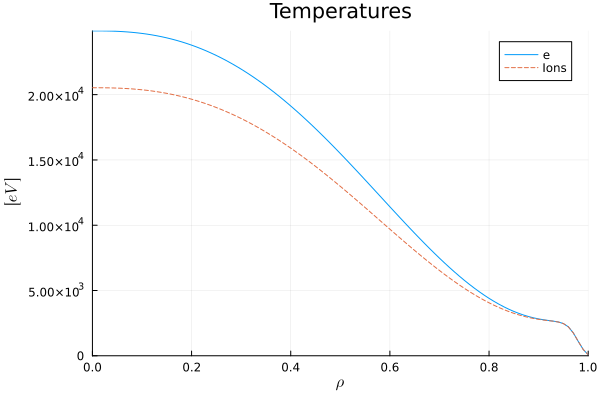

​


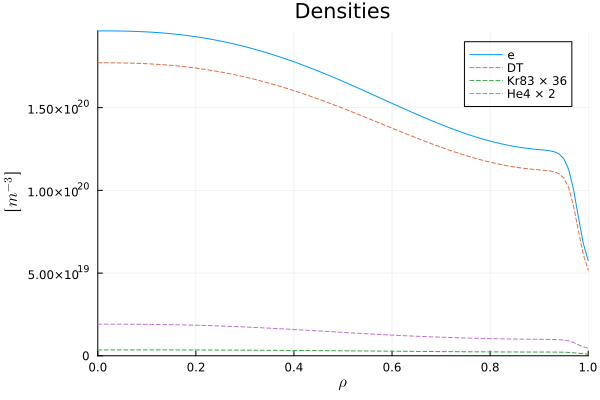

​


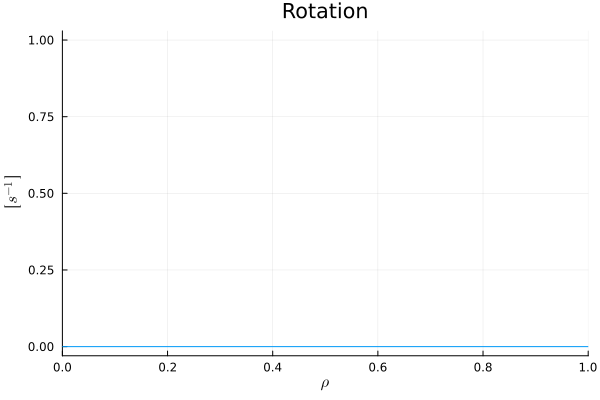

​


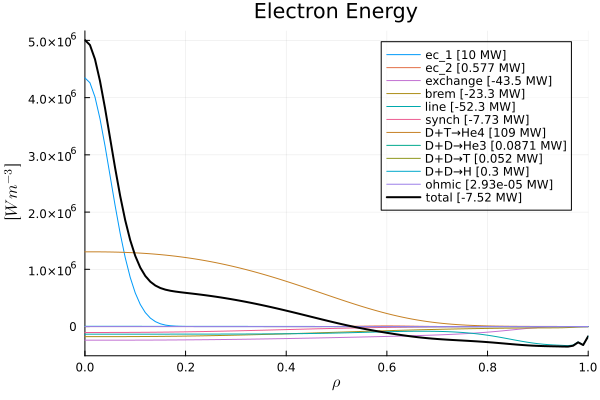

​


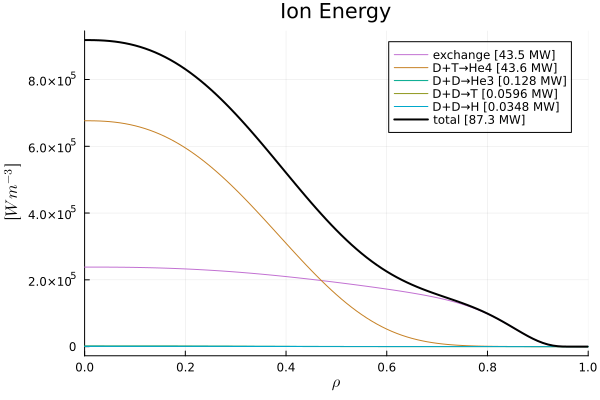

​


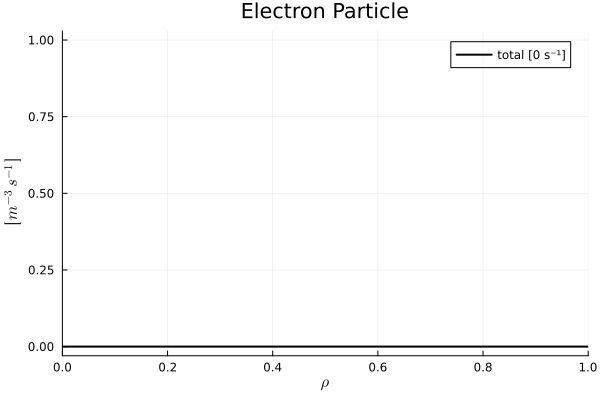

​


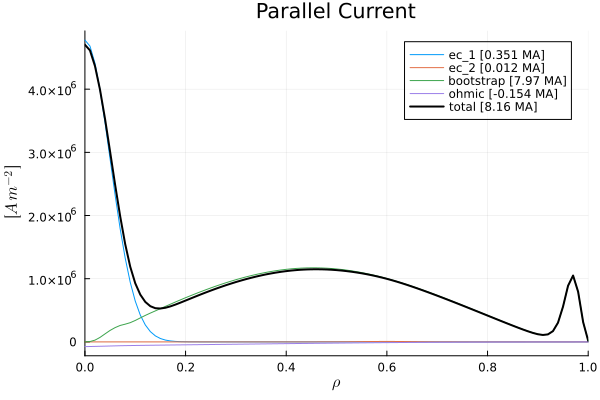

​


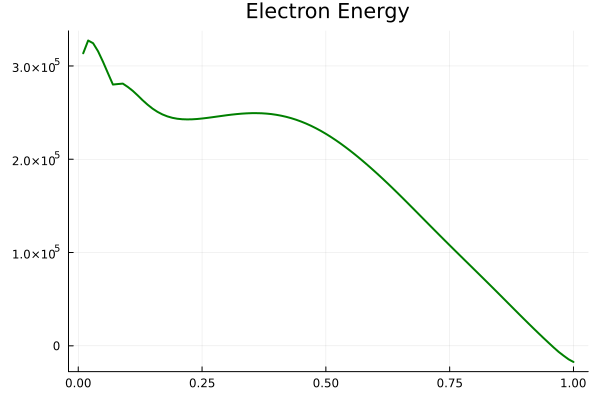

​


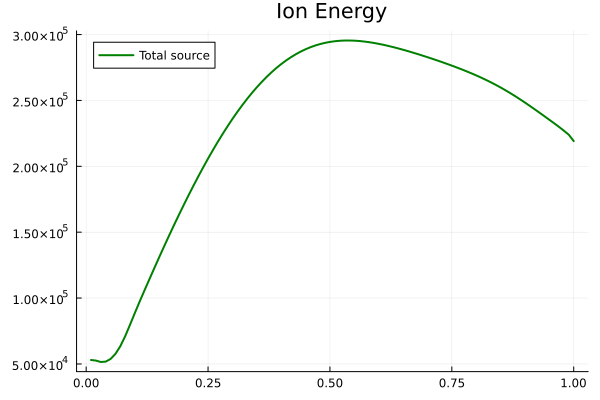

​


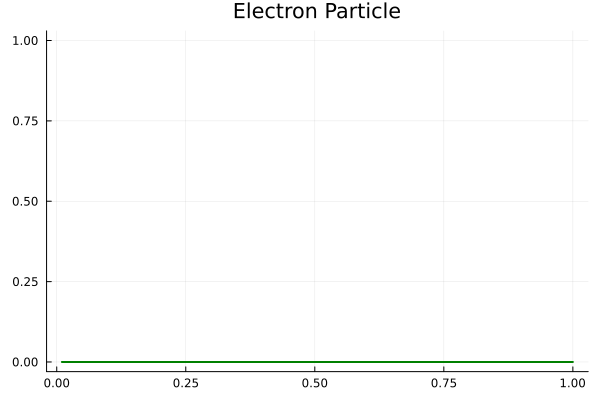

​


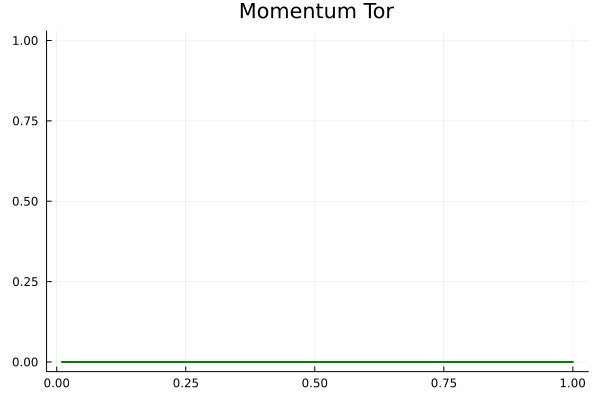

​


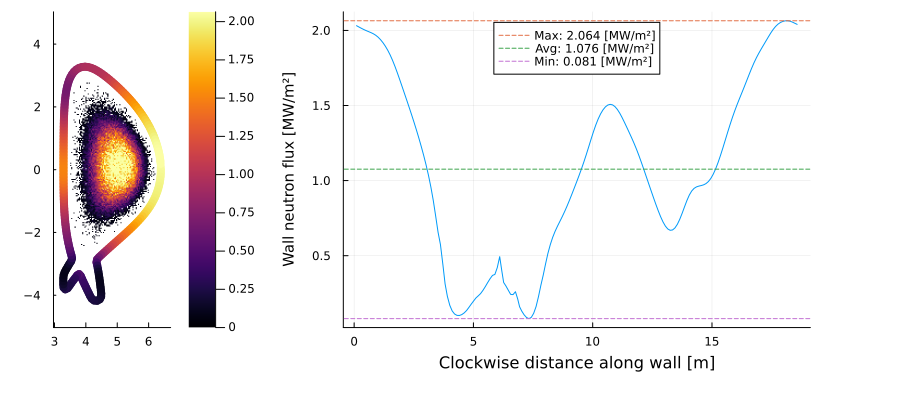

​


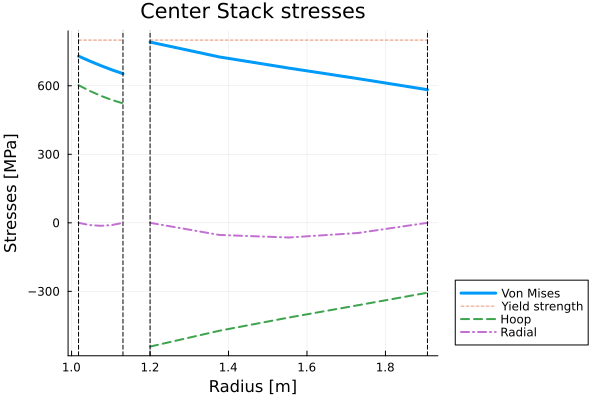

​


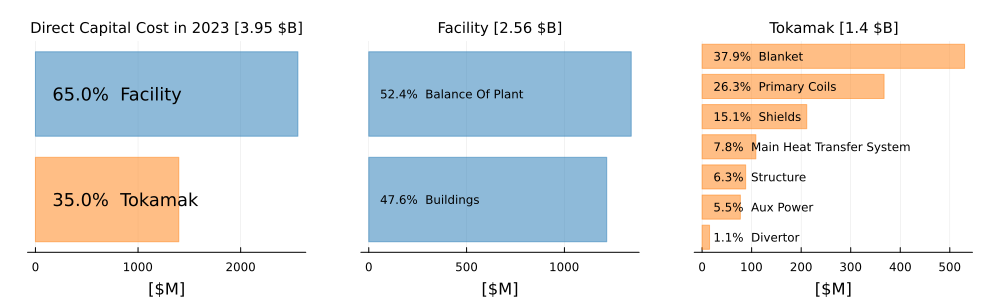

dir = "/fusion/ga/projects/ird/ptp/weisbergd/julia/dev/FUSE/playground/weisberg_FPP_opt/study_1/opt_betaN_cost__Solovev_flattop48/gen_runs4/1__2023-09-19T01:38:08.890__3919414"


"/fusion/ga/projects/ird/ptp/weisbergd/julia/dev/FUSE/playground/weisberg_FPP_opt/study_1/opt_betaN_cost__Solovev_flattop48/gen_runs4/1__2023-09-19T01:38:08.890__3919414"

In [18]:
n = argmax(outputs[:,"fBS"])
display(n)

dir = outputs[n, "dir"]
#n=length(dirs)
println(dir)
dd, ini, act = FUSE.load(dir)
FUSE.digest(dd)
@show dir

In [19]:
dd0 = deepcopy(dd)
act0 = deepcopy(act)
dd1 = deepcopy(dd)
act1 = deepcopy(act)

FUSE.ActorPedestal(dd0, act0);
FUSE.ActorCurrent(dd0, act0; ip_from=:equilibrium);

act1.ActorPedestal.only_powerlaw = true

FUSE.ActorPedestal(dd1, act1);
FUSE.ActorCurrent(dd1, act1; ip_from=:equilibrium);



┌ Warning: j_ohmic will change sign, as the non-inductive current 8.31383186e6 has larger magnitude than ip_target 8.108732966e6
└ @ FUSE /fusion/ga/projects/ird/ptp/weisbergd/julia/dev/FUSE/src/actors/current/steadycurrent_actor.jl:53
┌ Warning: j_ohmic will change sign, as the non-inductive current 8.31383186e6 has larger magnitude than ip_target 8.108732966e6
└ @ FUSE /fusion/ga/projects/ird/ptp/weisbergd/julia/dev/FUSE/src/actors/current/steadycurrent_actor.jl:53


pedestal
├─ n_e
│  └─ value ➡ [1.15107e+20] [m^-3]
├─ position
│  └─ rho_tor_norm ➡ [0.957194]
├─ t_e
│  └─ value ➡ [2306.86] [eV]
├─ t_i_average
│  └─ value ➡ [2306.86] [eV]
└─ zeff
   └─ value ➡ [1.71726]


pedestal
├─ n_e
│  └─ value ➡ [1.15107e+20] [m^-3]
├─ position
│  └─ rho_tor_norm ➡ [0.957195]
├─ t_e
│  └─ value ➡ [2307.09] [eV]
├─ t_i_average
│  └─ value ➡ [2307.09] [eV]
└─ zeff
   └─ value ➡ [1.71726]


pedestal
├─ n_e
│  └─ value ➡ [1.15107e+20] [m^-3]
├─ position
│  └─ rho_tor_norm ➡ [0.952682]
├─ t_e
│  └─ value ➡ [2976.82] [eV]
├─ t_i_average
│  └─ value ➡ [2976.82] [eV]
└─ zeff
   └─ value ➡ [1.71726]


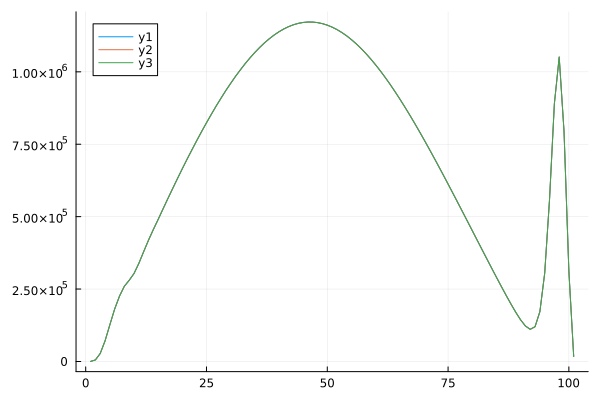

In [20]:
display(dd.summary.local.pedestal)
display(dd0.summary.local.pedestal)
display(dd1.summary.local.pedestal)

plot(dd.core_sources.source[3].profiles_1d[].j_parallel)
plot!(dd0.core_sources.source[3].profiles_1d[].j_parallel)
plot!(dd1.core_sources.source[3].profiles_1d[].j_parallel)


In [21]:
tmp = FUSE.EPEDNN.loadmodel("EPED1NNmodel.bson")
collect(zip(tmp.xnames, tmp.yp))
println(fieldnames(typeof(tmp)))
tmp.yp

(:fluxmodel, :name, :date, :xnames, :ynames, :xm, :xσ, :ym, :yσ, :xbounds, :ybounds, :yp)


18×11 Matrix{Float64}:
 -1.25479   0.221564  0.0321812  …  -0.353006   -0.473687  0.0787852
 -1.27548   0.177159  0.0293113     -0.326328   -0.426209  0.0958964
 -1.29243   0.181212  0.0262829     -0.311045   -0.417992  0.103192
 -1.27552   0.340866  0.031858      -0.354468   -0.535502  0.070493
 -1.27004   0.246578  0.0330649     -0.309033   -0.438389  0.100754
 -1.27222   0.239809  0.0288417  …  -0.291213   -0.426768  0.110349
 -1.30133   0.176081  0.0359485     -0.337447   -0.432691  0.0911147
 -1.28881   0.180439  0.0295002     -0.31492    -0.418693  0.10606
 -1.28864   0.191232  0.0252371     -0.302551   -0.423145  0.110335
 -0.751211  0.60903   0.0165972      0.073262   -0.235659  0.0392387
 -0.760498  0.587423  0.0151656  …   0.0866401  -0.212763  0.0478036
 -0.768984  0.589453  0.0136503      0.0942806  -0.208659  0.0514511
 -0.760506  0.669164  0.0164488      0.0725722  -0.267334  0.0351091
 -0.757804  0.622038  0.0170576      0.0952926  -0.218772  0.050225
 -0.758894  0.61864